#### Imports

In [1]:
#!pip install keras_facenet

In [2]:
#!pip install DeepFace

In [3]:
import os
import numpy as np
import cv2
from keras_facenet import FaceNet
from sklearn import svm
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from deepface import DeepFace
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

/Users/rohithram/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


***Generate reps is set to one if it is required to produce embeddings else it is set to 0***

In [3]:
generate_reps = 0

#### Create labels file from the given dataset

In [7]:
dir_train = "./train"
write_file_train = 'labels_train.txt'
dir_test = "./test"
write_file_test = 'labels_test.txt'

In [8]:
def create_labels(arg_dir, write_file):
    folder_names = os.listdir(arg_dir)
    # folder_names_train.remove('.DS_Store')
    labels_file = open(write_file, 'w')
    for each_folder in folder_names:
        current_folder_list = os.listdir(os.path.join(arg_dir, each_folder))
        for each_file in current_folder_list:
            labels_file.write(os.path.join(arg_dir, each_folder, each_file))
            labels_file.write(", "+ each_folder + "\n")
    labels_file.close()

In [9]:
create_labels(dir_train, write_file_train)
create_labels(dir_test, write_file_test)

***Extracting 1500 data samples per label for training and 300 data samples per label for testing***

In [4]:
labels_file_train = open("./labels_train_1500.txt", "r").read().splitlines()
labels_file_test = open("./labels_test_300.txt", "r").read().splitlines()

#### Face reps using Deepface

***Using the VGG-Face Model since it turned out to be the best among the other deep face models***

In [3]:
models = ["VGG-Face", "Facenet", "OpenFace", "Dlib", "ArcFace"]

In [13]:
import random

# Read the label_train file
with open("labels_train.txt", "r") as file:
    lines = file.readlines()

# Create a dictionary to store the images for each label
label_images = {}

# Iterate over each line in the label_train file
for line in lines:
    path, label = line.strip().split(", ")
    if label not in label_images:
        label_images[label] = []
    label_images[label].append(path)

# Create a new label_train file with 1500 random images for each label
with open("labels_train_1500.txt", "w") as file:
    for label, images in label_images.items():
        random_images = random.sample(images, min(1500, len(images)))
        for image in random_images:
            file.write(f"{image}, {label}\n")

In [14]:
import random

# Read the label_test file
with open("labels_test.txt", "r") as file:
    lines = file.readlines()

# Create a dictionary to store the images for each label
label_images = {}

# Iterate over each line in the label_test file
for line in lines:
    path, label = line.strip().split(", ")
    if label not in label_images:
        label_images[label] = []
    label_images[label].append(path)

# Create a new label_test file with 300 random images for each label
with open("labels_test_300.txt", "w") as file:
    for label, images in label_images.items():
        random_images = random.sample(images, min(300, len(images)))
        for image in random_images:
            file.write(f"{image}, {label}\n")

## Function for Image Augmentation

In [4]:
import cv2
import numpy as np

def augment_image(image):
    # Resizing the image
    resized_image = cv2.resize(image, (224, 224))  
    # Normalizing  pixel values
    normalized_image = resized_image / 255.0

    # Applying histogram equalization
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    equalized_image = cv2.equalizeHist(gray_image)

    # Applying random rotation
    rows, cols = equalized_image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((cols/2, rows/2), np.random.randint(-10, 10), 1)
    rotated_image = cv2.warpAffine(equalized_image, rotation_matrix, (cols, rows))

    # Applying random cropping
    crop_size = 200
    x = np.random.randint(0, cols - crop_size)
    y = np.random.randint(0, rows - crop_size)
    cropped_image = rotated_image[y:y+crop_size, x:x+crop_size]

    return cropped_image

In [16]:
from tqdm import tqdm
def create_deepface_reps(labels_file, csv_file):

    for line in tqdm(labels_file, desc="Processing"):
        split_arr = line.split(",")
        img_path = split_arr[0]
        label = split_arr[1]
        try:
            # Reading the image
            img = cv2.imread(img_path)

            # Applying image augmentation
            augmented_img = augment_image(img)

            # Converting the image to RGB if needed
            if len(augmented_img.shape) == 2:  # Grayscale image
                augmented_img = cv2.cvtColor(augmented_img, cv2.COLOR_GRAY2RGB)
            elif augmented_img.shape[2] == 1:  # Single channel image
                augmented_img = cv2.cvtColor(augmented_img, cv2.COLOR_GRAY2RGB)
            elif augmented_img.shape[2] == 4:  # RGBA image
                augmented_img = cv2.cvtColor(augmented_img, cv2.COLOR_RGBA2RGB)

            # Resizing the image to the required dimensions
            augmented_img = cv2.resize(augmented_img, (224, 224))

            # Generating face embeddings using DeepFace (VGG-Face)
            embeddings = DeepFace.represent(augmented_img, model_name=models[0], enforce_detection=False)
            
            # Saving the embeddings and label to the CSV file
            csv_file.write("{} , {}\n".format(embeddings[0]['embedding'], label))
        except Exception as e:
            print(f"Error processing image: {img_path}")
            print(f"Error message: {str(e)}")
            continue
    csv_file.close()

In [5]:
train_vgg = "./train_vgg.csv"
test_vgg = "./test_vgg.csv"

In [18]:
if generate_reps:
    csv_file_train_df = open(train_vgg, "w")
    csv_file_test_df = open(test_vgg, "w")

In [5]:
#Function to create deepface rep
if generate_reps:
    create_deepface_reps(labels_file_train, csv_file_train_df)
    create_deepface_reps(labels_file_test, csv_file_test_df)

#### Training using Deepface

In [6]:
final_train = "train_vgg_final.csv"
final_test = "test_vgg_final.csv"

In [7]:
def helper(fi, fi1):
    for i in range(len(fi)):
        x = fi[i].split(']')
        line =  (x[0]+ x[1]).split('[')[1]
        fi1.write(line+"\n")
    fi1.close()

In [8]:
file_train_df = open(train_vgg, "r").read().splitlines()
file_train_df_final = open(final_train, "w")
file_test_df = open(test_vgg, "r").read().splitlines()
file_test_df_final = open(final_test, "w")

In [9]:
helper(file_train_df, file_train_df_final)
helper(file_test_df, file_test_df_final)

In [10]:
df_train = pd.read_csv(final_train, header=None)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,4096
0,0.0,0.0,0.0,0.0,0.009205,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041233,happy
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happy
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.006253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happy
3,0.0,0.031064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.020456,0.0,0.0,happy
4,0.0,0.023036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.021105,0.0,0.0,0.0,0.0,0.0,happy


**Handling the rows with NaN values**

In [11]:
df_train.isnull().sum()

0       4
1       0
2       0
3       0
4       0
       ..
4092    0
4093    0
4094    0
4095    0
4096    0
Length: 4097, dtype: int64

In [12]:
df_train[0] = df_train[0].fillna(0)

In [12]:
le = LabelEncoder()
X_train = df_train.iloc[:, :-1].to_numpy()  # Features
y_train = le.fit_transform(df_train.iloc[:, -1]) # Target

label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print(label_mapping)

{'  angry': 0, '  disgust': 1, '  fear': 2, '  happy': 3, '  neutral': 4, '  sad': 5, '  surprise': 6}


In [13]:
import numpy as np

# Convert X_train to a float data type
X_train = X_train.astype(float)

# Check for NaN values in X_train
print("NaN values in X_train:")
print(np.isnan(X_train).sum())

# Get the indices of rows and columns containing NaN values
nan_rows, nan_cols = np.where(np.isnan(X_train))

# Print the indices of NaN values
print("\nIndices of NaN values:")
for row, col in zip(nan_rows, nan_cols):
    print(f"Row: {row}, Column: {col}")

NaN values in X_train:
16384

Indices of NaN values:
Row: 1103, Column: 0
Row: 1103, Column: 1
Row: 1103, Column: 2
Row: 1103, Column: 3
Row: 1103, Column: 4
Row: 1103, Column: 5
Row: 1103, Column: 6
Row: 1103, Column: 7
Row: 1103, Column: 8
Row: 1103, Column: 9
Row: 1103, Column: 10
Row: 1103, Column: 11
Row: 1103, Column: 12
Row: 1103, Column: 13
Row: 1103, Column: 14
Row: 1103, Column: 15
Row: 1103, Column: 16
Row: 1103, Column: 17
Row: 1103, Column: 18
Row: 1103, Column: 19
Row: 1103, Column: 20
Row: 1103, Column: 21
Row: 1103, Column: 22
Row: 1103, Column: 23
Row: 1103, Column: 24
Row: 1103, Column: 25
Row: 1103, Column: 26
Row: 1103, Column: 27
Row: 1103, Column: 28
Row: 1103, Column: 29
Row: 1103, Column: 30
Row: 1103, Column: 31
Row: 1103, Column: 32
Row: 1103, Column: 33
Row: 1103, Column: 34
Row: 1103, Column: 35
Row: 1103, Column: 36
Row: 1103, Column: 37
Row: 1103, Column: 38
Row: 1103, Column: 39
Row: 1103, Column: 40
Row: 1103, Column: 41
Row: 1103, Column: 42
Row: 1103, 

**Handling missing values**

In [14]:
import numpy as np

# Print the original shapes of X_train and y_train
print("Original shape of X_train:", X_train.shape)
print("Original shape of y_train:", y_train.shape)

# Create a boolean mask for rows to keep (rows not in nan_rows)
keep_rows = np.ones(X_train.shape[0], dtype=bool)
keep_rows[nan_rows] = False

# Remove rows specified in nan_rows from X_train using boolean indexing
X_train_clean = X_train[keep_rows]

# Remove corresponding rows from y_train using boolean indexing
y_train_clean = y_train[keep_rows]

# Print the shapes of the cleaned arrays
print("Shape of X_train_clean:", X_train_clean.shape)
print("Shape of y_train_clean:", y_train_clean.shape)

Original shape of X_train: (9531, 4096)
Original shape of y_train: (9531,)
Shape of X_train_clean: (9527, 4096)
Shape of y_train_clean: (9527,)


**Training the SVM model**

In [15]:
clf = svm.SVC(C=100, gamma=0.1, kernel='rbf')
clf.fit(X_train_clean, y_train_clean) 

SVC(C=100, gamma=0.1)

In [16]:
# Calculate the training accuracy
train_accuracy = clf.score(X_train_clean, y_train_clean)

# Print the training accuracy
print("Training Accuracy:", train_accuracy)

Training Accuracy: 0.9904481998530492


***Very High Training accuracy - suggests that the data could be overfitting***

In [19]:
df_test.isnull().sum()

0       0
1       0
2       0
3       0
4       0
       ..
4092    0
4093    0
4094    0
4095    0
4096    0
Length: 4097, dtype: int64

In [20]:
X_test = df_test.iloc[:, :-1].to_numpy()  # Features
y_test = le.fit_transform(df_test.iloc[:, -1]) # Target

label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print(label_mapping)

{'  angry': 0, '  disgust': 1, '  fear': 2, '  happy': 3, '  neutral': 4, '  sad': 5, '  surprise': 6}


In [21]:
y_predicted = clf.predict(X_test)

In [22]:
print("Test accuracy: ", accuracy_score(y_test, y_predicted))

Test accuracy:  0.4599686028257457


***The testing accuracy has reduced considerably from the testing accuracy without augmentation***

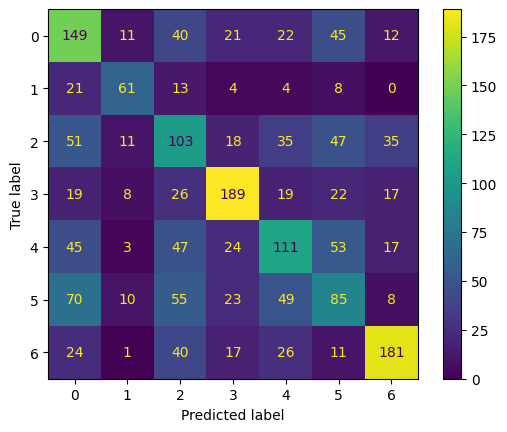

In [23]:
cm_vgg = confusion_matrix(y_test, y_predicted, labels=clf.classes_)
disp = ConfusionMatrixDisplay(cm_vgg, display_labels=clf.classes_)
disp.plot()
plt.show()

#### Training using MLP

In [25]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(50,50), activation='relu', solver='adam', max_iter=1000).fit(X_train_clean, y_train_clean)

In [26]:
y_predicted_mlp = mlp_clf.predict(X_test)

***MLP also produced a very low testing accuracy*** 

In [27]:
print("Test accuracy: ", accuracy_score(y_test, y_predicted_mlp))

Test accuracy:  0.4400837257980115


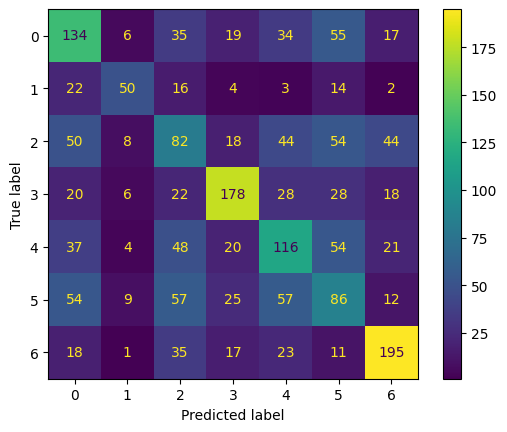

In [28]:
cm_mlp = confusion_matrix(y_test, y_predicted_mlp, labels=clf.classes_)
disp = ConfusionMatrixDisplay(cm_mlp, display_labels=clf.classes_)
disp.plot()
plt.show()